In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
import nltk

In [10]:
from google.colab import files
uploaded = files.upload()

Saving Roosevelt_1904.txt to Roosevelt_1904.txt


In [4]:
from google.colab import files
clinton_upload = files.upload()

Saving Clinton_1996.txt to Clinton_1996.txt


In [5]:
uploaded


{}

## Cleaning


In [11]:
#Takes apart the dictionary into just values and returns to variable assigned

roose = list(uploaded.values())
clint = list(clinton_upload.values())

#Turns list into string
roose_str = ' '.join(str(x) for x in roose)
clint_str = ' '.join(str(x) for x in clint)


clint_str

'b"Mr. Speaker, Mr. Vice President, members of the 104th Congress,\\ndistinguished guests, my fellow Americans all across our land:\\n\\nLet me begin tonight by saying to our men and women in uniform around the\\nworld, and especially those helping peace take root in Bosnia and to their\\nfamilies, I thank you. America is very, very proud of you.\\n\\nMy duty tonight is to report on the state of the Union--not the state of\\nour government, but of our American community; and to set forth our\\nresponsibilities, in the words of our Founders, to form a more perfect\\nunion.\\n\\nThe state of the Union is strong. Our economy is the healthiest it has been\\nin three decades. We have the lowest combined rates of unemployment and\\ninflation in 27 years. We have created nearly 8 million new jobs, over a\\nmillion of them in basic industries, like construction and automobiles.\\nAmerica is selling more cars than Japan for the first time since the 1970s.\\nAnd for three years in a row, we have

In [12]:

#Getting rid of newlines and first random letter/space

roose_str = re.sub(r'\\n', ' ', roose_str)
clint_str = re.sub(r'\\n', ' ', clint_str)
roose_str

roosevelt = roose_str[2:]
clinton = clint_str[2:]
clinton

'Mr. Speaker, Mr. Vice President, members of the 104th Congress, distinguished guests, my fellow Americans all across our land:  Let me begin tonight by saying to our men and women in uniform around the world, and especially those helping peace take root in Bosnia and to their families, I thank you. America is very, very proud of you.  My duty tonight is to report on the state of the Union--not the state of our government, but of our American community; and to set forth our responsibilities, in the words of our Founders, to form a more perfect union.  The state of the Union is strong. Our economy is the healthiest it has been in three decades. We have the lowest combined rates of unemployment and inflation in 27 years. We have created nearly 8 million new jobs, over a million of them in basic industries, like construction and automobiles. America is selling more cars than Japan for the first time since the 1970s. And for three years in a row, we have had a record number of new business

In [0]:
import spacy
nlp = spacy.load('en')


# All the processing work is done here, so it may take a while.
roosevelt = nlp(roosevelt)
clinton= nlp(clinton)

## Exploration

In [14]:
# Let's explore the objects we've built.
print("The roose object is a {} object.".format(type(roosevelt)))
print("It is {} tokens long".format(len(roosevelt)))
print("The first three tokens are '{}'".format(roosevelt[:3]))
print("The type of each token is {}".format(type(roosevelt[0])))

The roose object is a <class 'spacy.tokens.doc.Doc'> object.
It is 19245 tokens long
The first three tokens are 'To the Senate'
The type of each token is <class 'spacy.tokens.token.Token'>


In [0]:
#Find the most common words

from collections import Counter

# Utility function to calculate how frequently words appear in the text.
def word_frequencies(text, include_stop=True):
    
    # Build a list of words.
    # Strip out punctuation and, optionally, stop words.
    words = []
    for token in text:
        if not token.is_punct and (not token.is_stop or include_stop):
            words.append(token.text)
            
    # Build and return a Counter object containing word counts.
    return Counter(words)
    
# The most frequent words:
roose_freq = word_frequencies(roosevelt).most_common(10)

print(roose_freq)


## Code still including stop words (?) based on caps. Including spaces as well

In [0]:
# Use our optional keyword argument to remove stop words.
roose_freq = word_frequencies(roosevelt, include_stop=False).most_common(10)

print('Roose:', roose_freq)


In [0]:
# Utility function to calculate how frequently lemas appear in the text.
def lemma_frequencies(text, include_stop=True):
    
    # Build a list of lemas.
    # Strip out punctuation and, optionally, stop words.
    lemmas = []
    for token in text:
        if not token.is_punct and (not token.is_stop or include_stop):
            lemmas.append(token.lemma_)
            
    # Build and return a Counter object containing word counts.
    return Counter(lemmas)

# Instantiate our list of most common lemmas.
roose_lemma_freq = lemma_frequencies(roosevelt, include_stop=False).most_common(10)

print('Roose Lemmas:', roose_lemma_freq)


In [0]:
# Initial exploration of sentences.
sentences = list(roosevelt.sents)
print("Roosevelt's State of the Union Address has {} sentences.".format(len(sentences)))

example_sentence = sentences[2]
print("Here is an example: \n{}\n".format(example_sentence))
print('\nParts of speech:')
for token in example_sentence[:9]:
    print(token.orth_, token.pos_)
    print('\nDependencies:')
for token in example_sentence[:9]:
    print(token.orth_, token.dep_, token.head.orth_)

In [0]:
# Extract the first ten entities.
entities = list(roosevelt.ents)[0:10]
for entity in entities:
    print(entity.label_, ' '.join(t.orth_ for t in entity))

In [0]:
people = [entity.text for entity in list(roosevelt.ents) if entity.label_ == "PERSON"]
print(set(people))

In [0]:
# Look at some metrics around this sentence.
example_words = [token for token in example_sentence if not token.is_punct]
unique_words = set([token.text for token in example_words])

print(("There are {} words in this sentence, and {} of them are"
       " unique.").format(len(example_words), len(unique_words)))

##Getting ready to model

In [32]:
roose_sents = [[sent, "Roosevelt", 56.4] for sent in roosevelt.sents]
clint_sents = [[sent, "Clinton", 49.2] for sent in clinton.sents]


sentences = pd.DataFrame(roose_sents + clint_sents)
sentences.head()

,0,1,2
0,"(To, the, Senate, and, House, of, Representati...",Roosevelt,56.4
1,"(Such, prosperity, is, of, course, primarily, ...",Roosevelt,56.4
2,"(The, people, have, emphatically, expressed, t...",Roosevelt,56.4
3,"(The, enlargement, of, scope, of, the, functio...",Roosevelt,56.4
4,"(Battle, ships, and, forts, ,, public, buildin...",Roosevelt,56.4


In [0]:
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df['Popular_vote'] = sentences[2]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 50 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
roose_words = bag_of_words(roosevelt)
clint_words = bag_of_words(clinton)

# Combine bags to create a set of unique words.
common_words = set(roose_words + clint_words)


In [17]:
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 50
Processing row 100
Processing row 150
Processing row 200
Processing row 250
Processing row 300
Processing row 350
Processing row 400
Processing row 450
Processing row 500
Processing row 550
Processing row 600
Processing row 650
Processing row 700
Processing row 750
Processing row 800
Processing row 850
Processing row 900


,education,respective,independent,equal,partnership,worker,wide,troop,protection,most,abroad,switch,money,comprehensive,utility,continuation,federal,full,decorate,an,attitude,numerous,avenue,flexibility,resistance,engage,smoking,vice,significant,locality,mississippi,arrangement,approve,service,act,tendency,vocation,change,mark,belong,...,identify,achieve,distinguished,creature,sailing,office,co,essential,programming,america,rim,meeting,limited,success,conspicuous,fashioned,among,review,acquaintance,cropping,consider,home,hatred,reach,great,civil,currency,department,cruiser,wife,destine,read,refugee,drug,families,plymouth,judicial,text_sentence,text_source,Popular_vote
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"(To, the, Senate, and, House, of, Representati...",Roosevelt,56.4
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,"(Such, prosperity, is, of, course, primarily, ...",Roosevelt,56.4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"(The, people, have, emphatically, expressed, t...",Roosevelt,56.4
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,"(The, enlargement, of, scope, of, the, functio...",Roosevelt,56.4
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"(Battle, ships, and, forts, ,, public, buildin...",Roosevelt,56.4


# Random Forest

In [18]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source', 'Popular_vote'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.9908088235294118

Test set score: 0.7445054945054945


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Super overfit!

#Trying Log Regression with Bag of Words

In [0]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2') # No need to specify l2 as it's the default. But we put it for demonstration.
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

##Increase the training set to make more accurate for test set

In [0]:
rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source', 'Popular_vote'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.2,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

lr = LogisticRegression(penalty='l2') # No need to specify l2 as it's the default. But we put it for demonstration.
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

#Huge improvement to the test set!

#Gradient Boost

In [0]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Not great, better than random forest though

#Unsupervised model

In [59]:
for each in sentences[0]:
  str(each)


0    object
1    object
2    object
dtype: object


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(sentences, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.1, # drop words that occur in more than .1 the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )




In [65]:
sentences

,0,1,2
0,To the Senate and House of Representatives: T...,Roosevelt,56.4
1,Such prosperity is of course primarily due to ...,Roosevelt,56.4
2,The people have emphatically expressed their a...,Roosevelt,56.4
3,The enlargement of scope of the functions of t...,Roosevelt,56.4
4,"Battle ships and forts, public buildings, and ...",Roosevelt,56.4
5,The cost of doing Government business should b...,Roosevelt,56.4
6,In the vast and complicated mechanism of our m...,Roosevelt,56.4
7,"Our peculiar form of government, with its shar...",Roosevelt,56.4
8,But it is undoubtedly responsible for much of ...,Roosevelt,56.4
9,In actual practice it has proved exceedingly d...,Roosevelt,56.4


In [64]:

#Applying the vectorizer
pres_vec =vectorizer.fit_transform(sentences[0])
print("Number of features: %d" % pres_vec.get_shape()[1])

#splitting into training and test sets
X_train_vec, X_test_vec= train_test_split(pres_vec, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_vec_read = X_train_vec.tocsr()

#number of sentences
n = X_train_vec_read.shape[0]
#A list of dictionaries, one per sentence
tfidf_bysent = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each sentence, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_vec_read.nonzero()):
    tfidf_bysent[i][terms[j]] = X_train_vec_read[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print(n)
print(tfidf_bysent)


Number of features: 1621
544
[{'challenge': array(0.34835951), 'businesses': array(0.46547672), 'force': array(0.4370508), 'american': array(0.33655211), 'work': array(0.2919398), 'welfare': array(0.43122213), 'people': array(0.29413427)}, {'tuition': array(0.1957226), 'expand': array(0.3914452), '2000': array(0.18733593), 'percent': array(0.16369522), 'challenge': array(0.12020964), 'tax': array(0.1671289), 'americans': array(0.12859632), 'merit': array(0.18733593), '000': array(0.16369522), '10': array(0.18733593), 'deserving': array(0.1957226), 'year': array(0.26782292), 'million': array(0.15530855), 'students': array(0.18733593), 'college': array(0.35103115), 'school': array(0.1671289), 'provide': array(0.1529751), 'young': array(0.17102169), 'grant': array(0.18083072), 'united': array(0.12764041), 'study': array(0.17102169), 'congress': array(0.10561075), 'make': array(0.11613522), 'work': array(0.20148139), 'help': array(0.14880334), 'way': array(0.13510152), 'states': array(0.11

In [66]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_vec)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of sentences our solution considers similar, for the first five identified topics
sents_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(sents_by_component.loc[:,i].sort_values(ascending=False)[0:10])




Percent variance captured by all components: 49.245466039540055
Component 0:
(I challenge American businesses to give people on welfare the chance to move into the work force., Clinton, 49.2)                                                                                                                                                                                                                                                                                                0.487171
(Our seventh challenge is really America's challenge to those of us in this hallowed hall tonight: to reinvent our government and make our democracy work for them.  , Clinton, 49.2)                                                                                                                                                                                                                             0.460080
(As we move into the era of balanced budgets and smaller government, we must work in new ways to enab

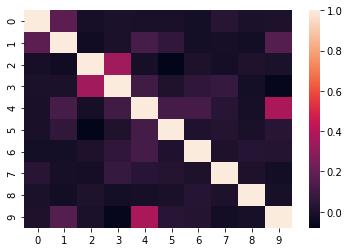

Key:
0 ('I challenge American businesses to give people on welfare the chance to move into the work force.', 'Clinton', '49.2')
1 ('I challenge Congress to expand work-study and help one million young Americans work their way through college by the year 2000; to provide a $1000 merit scholarship for the top five percent of graduates in every high school in the United States; to expand Pell Grant scholarships for deserving and needy students; and to make up to $10,000 a year of college tuition tax deductible.', 'Clinton', '49.2')
2 ('The best officers and men in a poor ship could do nothing against fairly good opponents; and on the other hand a modern war ship is useless unless the officers and men aboard her have become adepts in their duties.', 'Roosevelt', '56.4')
3 ('It is commonly declared that the slow advance of the Indians is due to the unsatisfactory character of the men appointed to take immediate charge of them, and to some extent this is true.', 'Roosevelt', '56.4')
4 ('The 

In [67]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])